In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [2]:
PATH = os.path.expanduser("~/data/dogbreed")
arch = resnext101_64
SZ = 224 # image size
bs = 16 # batch size (initial value of 64 was too large @ end and I couldn't reuse the saved models)

In [3]:
!ls {PATH}

labels.csv  models  test  tmp  train


In [4]:
label_csv = f'{PATH}/labels.csv'
with open(label_csv) as f: n = len(list(f)) - 1
val_idxs = get_cv_idxs(n)

In [5]:
val_idxs[:5]

array([2882, 4514, 7717,   33, 4924])

In [6]:
def get_data(f_model, sz, bs):
    """f_model: architecture, e.g. resnet34
    sz: scale images to sz by sz pixels
    bs: batch size (how many images to consider together)"""
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', bs=bs)
    return data if sz > 300 else data.resize(340, 'tmp')

In [7]:
data = get_data(arch, SZ, bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [8]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
# learn.lr_find()
# learn.sched.plot()

In [17]:
learn.fit(0.1, 5, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.661708   0.40466    0.896484  
    1      0.507911   0.353431   0.90625                      
    2      0.523182   0.453661   0.898438                     
    3      0.531866   0.424222   0.904785                     
    4      0.546759   0.552184   0.898438                     



[0.55218387, 0.8984375]

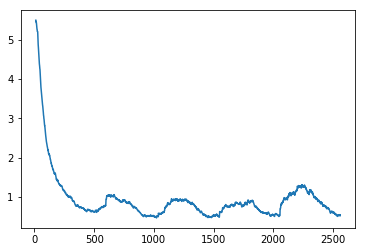

In [18]:
learn.sched.plot_loss()

In [19]:
learn.save("224_pre_rnx101")

In [20]:
learn.load("224_pre_rnx101")

In [21]:
learn.precompute = False
learn.fit(0.1, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.747908   0.475555   0.902832  
    1      0.933956   0.518539   0.904297                    
    2      1.317818   0.690021   0.905273                   



[0.69002104, 0.9052734375]

In [22]:
learn.save("224_no_precompute_rnx101")

In [10]:
learn.precompute = False # repetition of previous assignment, but necessary if we skip some cells...
learn.load("224_no_precompute_rnx101")

In [12]:
learn.set_data(get_data(arch, 299, bs))
learn.freeze()
learn.fit(0.01, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  4%|▍         | 20/512 [00:08<03:21,  2.45it/s, loss=1.64]


Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.874644   0.59973    0.908691  
    1      0.9118     0.521057   0.911133                    
    2      0.667968   0.47453    0.913086                    



[0.4745297, 0.9130859375]

In [13]:
 learn.save("299_no_precompute_rnx101")

In [18]:
learn.fit(0.01, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.417061   0.441097   0.913574  
    1      0.554286   0.382483   0.915527                    
    2      0.437246   0.379981   0.916016                    
    3      0.405251   0.356474   0.913086                    
    4      0.375019   0.331964   0.916016                    
    5      0.361718   0.31771    0.916992                    
    6      0.383466   0.315023   0.916992                    



[0.31502342, 0.9169921875]

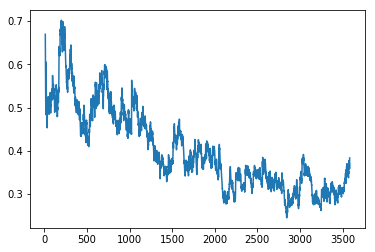

In [19]:
learn.sched.plot_loss()

In [20]:
learn.save("224_after_cycl_mult")

In [22]:
log_preds,y = learn.TTA(n_aug=8)
probs = np.mean(np.exp(log_preds),0)

In [23]:
accuracy_np(probs, y)

0.9285714285714286

In [24]:
import sklearn.metrics

In [25]:
log_preds.shape, y.shape

((10, 2044, 120), (2044,))

In [26]:
sklearn.metrics.log_loss(y, probs)

0.26168244903517524

If my intrepretation of `sklearn.metrics.log_loss` is correct, on [2018-04-10], I am about 425th with this model.